<a href="https://colab.research.google.com/github/khushboo0824/cognitive-assessment-/blob/main/ML/ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khushboochauhan08","key":"1f0a8cdbb234c5e6b881934f26aac3f1"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy


Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 91% 65.0M/71.5M [00:01<00:00, 51.0MB/s]
100% 71.5M/71.5M [00:01<00:00, 56.6MB/s]


In [4]:
import zipfile

dataset_path = "/content/best-alzheimer-mri-dataset-99-accuracy.zip"
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("/content/MRI_Dataset")


In [5]:
import os
import pandas as pd
import numpy as np
from matplotlib import image

import seaborn as sns
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.io import imread
from skimage.color import rgb2gray

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



sns.set_palette('Paired')
sns.set_style("whitegrid")

In [6]:
# class1 = 'Very_Mild_Demented/'
# class2 = 'Mild_Demented/'
# class3 = 'Moderate_Demented/'
# class0 = 'Non_Demented/'


class1 = '/content/MRI_Dataset/Combined Dataset/train/Moderate Impairment'
class2 = '/content/MRI_Dataset/Combined Dataset/train/No Impairment'
class3 = '/content/MRI_Dataset/Combined Dataset/train/Very Mild Impairment'
class0 = '/content/MRI_Dataset/Combined Dataset/train/Mild Impairment'

In [7]:
class1_test = '/content/MRI_Dataset/Combined Dataset/test/Moderate Impairment'
class2_test = '/content/MRI_Dataset/Combined Dataset/test/No Impairment'
class3_test = '/content/MRI_Dataset/Combined Dataset/test/Very Mild Impairment'
class0_test = '/content/MRI_Dataset/Combined Dataset/test/Mild Impairment'

In [8]:
def file_append(class_path):
    image_array = []
    curr_path = os.path.join(os.getcwd(),class_path)
    cnt = 0
    file_list = [k for k in os.listdir(curr_path) if '.jpg' in k]
    for x in file_list:

        img_path = os.path.join(curr_path,x)

        img = imread(img_path)
#         img = rgb2gray(img)
        img = resize(img,(60,60,3))     ## Will need to change this resize parameter
        img = img.flatten()
        image_array.append(img)

    return image_array


class1_img = file_append(class1)
class2_img = file_append(class2)
class3_img = file_append(class3)
class0_img = file_append(class0)

In [9]:
# Load test images
test_class1 = file_append(class1_test)
test_class2 = file_append(class2_test)
test_class3 = file_append(class3_test)
test_class0 = file_append(class0_test)

In [10]:
df1 = pd.DataFrame(class1_img)
df1['y']  = 1
df2 = pd.DataFrame(class2_img)
df2['y']  = 2
df3 = pd.DataFrame(class3_img)
df3['y']  = 3
df0 = pd.DataFrame(class0_img)
df0['y']  = 0

df = pd.concat([df0,df1,df2,df3],ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,10791,10792,10793,10794,10795,10796,10797,10798,10799,y
0,0.028982,0.028982,0.028982,0.011224,0.011224,0.011224,0.002778,0.002778,0.002778,0.000769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.025509,0.025509,0.025509,0.010219,0.010219,0.010219,0.002412,0.002412,0.002412,0.000751,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.020565,0.020565,0.020565,0.006155,0.006155,0.006155,0.000083,0.000083,0.000083,0.001039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [11]:
df_test1 = pd.DataFrame(test_class1)
df_test1['y'] = 1
df_test2 = pd.DataFrame(test_class2)
df_test2['y'] = 2
df_test3 = pd.DataFrame(test_class3)
df_test3['y'] = 3
df_test0 = pd.DataFrame(test_class0)
df_test0['y'] = 0

In [12]:
df_train = pd.concat([df0, df1, df2, df3], ignore_index=True)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [13]:
df_test = pd.concat([df_test0, df_test1, df_test2, df_test3], ignore_index=True)

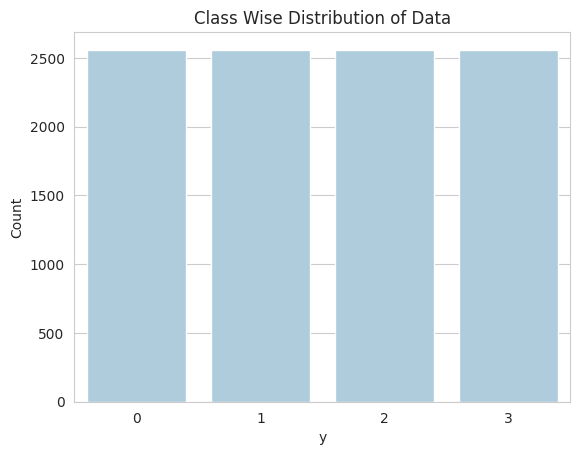

In [ ]:
class_counts = df['y'].value_counts().sort_index()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.ylabel('Count')
plt.title('Class Wise Distribution of Data')
plt.show()


In [ ]:
train_dir = "/content/MRI_Dataset/Combined Dataset/train"
test_dir = "/content/MRI_Dataset/Combined Dataset/test"

In [14]:
X_train = df_train.drop(columns=['y'])
y_train = df_train['y']
X_test = df_test.drop(columns=['y'])
y_test = df_test['y']


In [15]:
pca = PCA()
X_pca = pca.fit_transform(X_train)  # X is your feature set (already flattened images or processed features)
X_test_pca = pca.transform(X_test)

In [ ]:
print(X_pca.shape, X_test_pca.shape)

(10240, 10240) (1279, 10240)


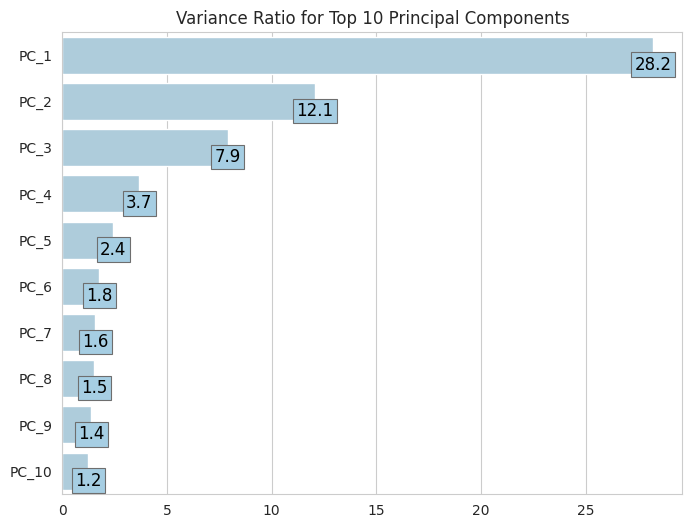

In [ ]:
# Step 2: Extract the explained variance ratio for the top 10 principal components
top10_var = [x * 100 for x in pca.explained_variance_ratio_[:10]]
PC_labels = ['PC_' + str(x + 1) for x in range(len(top10_var))]

# Step 3: Plot the explained variance for the top 10 components
plt.figure(figsize=(8, 6))
plt.title("Variance Percentage for Top 10 Principal Components")
bar = sns.barplot(x=top10_var, y=PC_labels)

# Step 4: Annotate the bars with the exact variance values
for p in bar.patches:
    x = p.get_width()
    y = p.get_y()
    bar.annotate(format(x, '.1f'), (x, y), ha='center', va='center', size=12, color='black',
                 xytext=(0, -20), textcoords='offset points',
                 bbox=dict(boxstyle='square,pad=0.2', lw=0.8, ec='#6e6e6e'))

plt.title("Variance Ratio for Top 10 Principal Components")
plt.show()

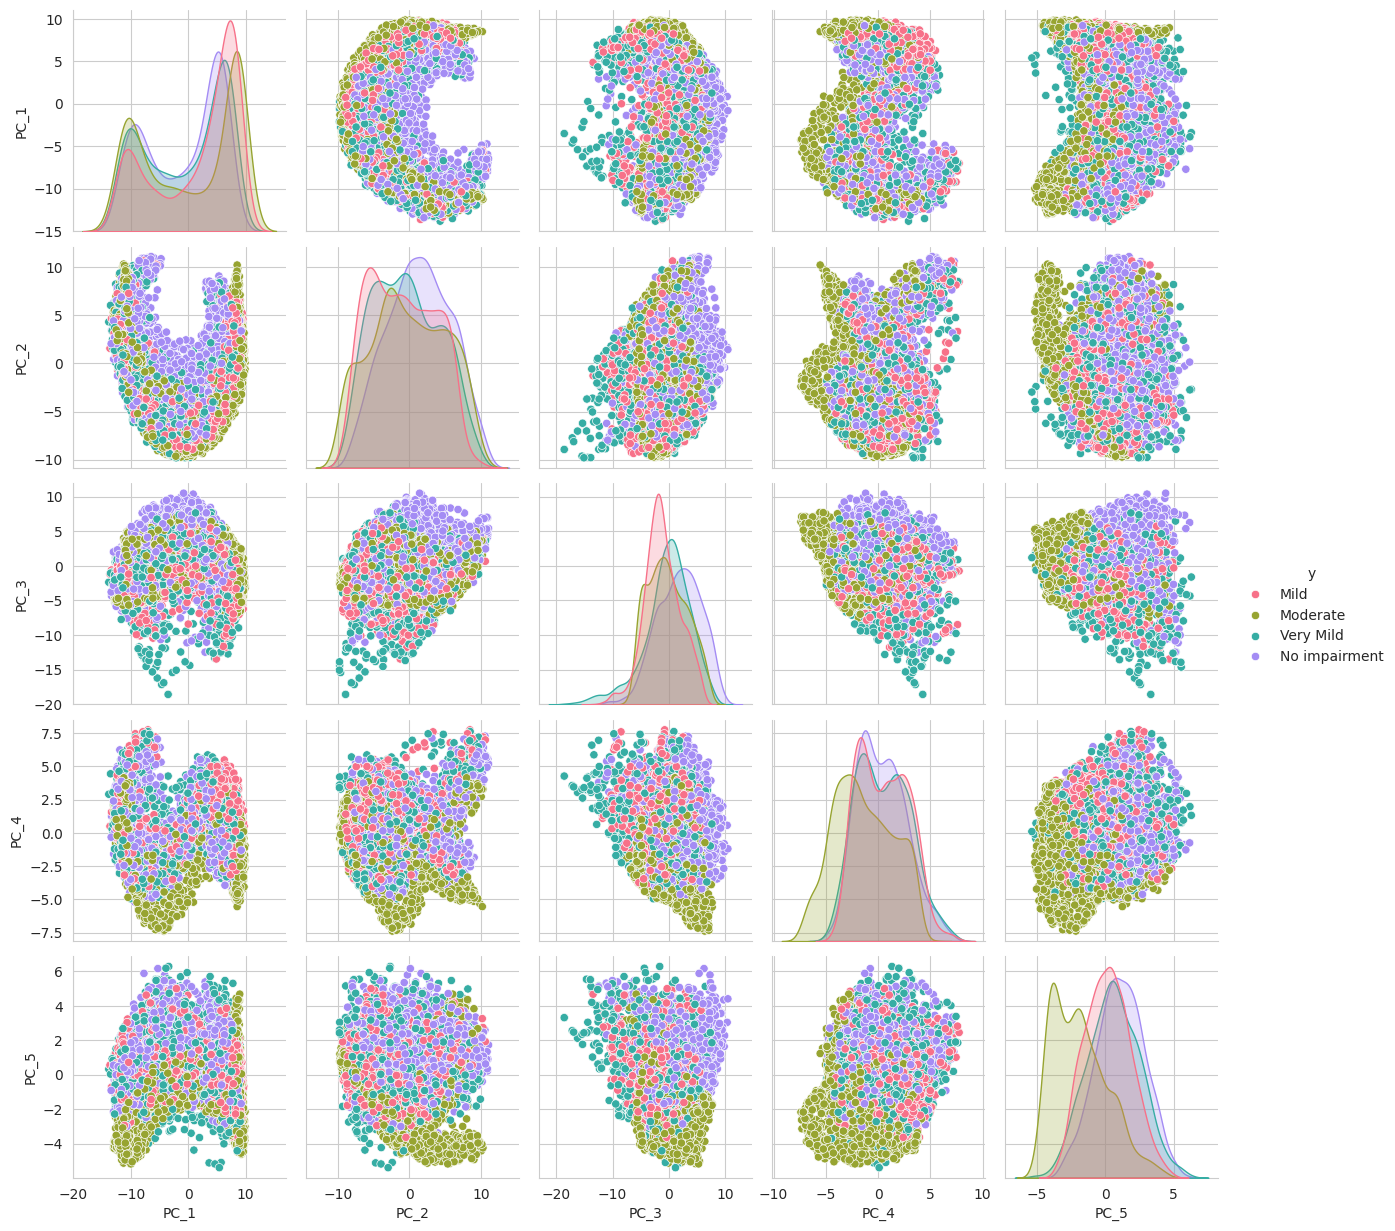

In [ ]:
scatter_plots = X_pca[:,:5]
data_cols = ['PC_'+str(x+1) for x in range(scatter_plots.shape[1]) ]
scatter_df = pd.DataFrame(scatter_plots,columns=data_cols)
scatter_df['y'] = y_train.reset_index(drop=True)

label_map = {0:'Mild',1:'Moderate', 2: 'No impairment',3:'Very Mild'}
scatter_df['y'] = scatter_df['y'].map(label_map)

sns.pairplot(scatter_df,hue="y",palette="husl",)

In [17]:
#function to train model using GridSearchCV
def train_model(model, search_grid, X_train, y_train):
    cv = KFold(n_splits=10)
    grid_search = GridSearchCV(estimator=model, param_grid=search_grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
    grid_result = grid_search.fit(X_train, y_train)
    return grid_result

#Function to plot cross-validation results
def scatter_plots(score_array, title):
    sns.set_palette('CMRmap')
    lr_scores = score_array.cv_results_['mean_test_score']
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=range(1, len(lr_scores) + 1), y=lr_scores)  # Fix here
    plt.scatter(range(1, len(lr_scores) + 1), lr_scores)

    plt.xlabel('Cross Validation Steps')
    plt.ylabel('Model Accuracy')
    plt.title(f'Cross Validation Accuracies for {title}', size=15)

    for i, j in enumerate(lr_scores):
        if j == max(lr_scores):
            plt.scatter(i + 1, j, c='red', marker='o', s=200)
            plt.annotate(format(j, '.3f'), (i + 1, j), size=15)
    plt.show()

#Function to plot confusion matrix
def cf_plot(model, X_test, y_test, title):
    plt.figure(figsize=(9, 7))
    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)

    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 15})

    plt.xlabel('Predicted Label', size=15)
    plt.ylabel('Actual Label', size=15)
    plt.title(f'Confusion Matrix for {title}', size=15)
    plt.show()

Logistic Regression

In [ ]:
lr_model = LogisticRegression(max_iter=100)

solvers = ['newton-cg']
penalty = ['l2']
c_values = [ 1.0, 0.1, 0.01,0.001]
lr_search_grid = dict(solver=solvers, penalty=penalty, C=c_values)


lr_grid_result = train_model(lr_model, lr_search_grid, X_pca, y_train)

In [ ]:
print(lr_grid_result.cv_results_)


{'mean_fit_time': array([155.32443633, 120.583722  ,  80.76149256,  55.43961425]), 'std_fit_time': array([3.42525457, 9.90126087, 5.34983094, 8.48694297]), 'mean_score_time': array([0.04986048, 0.05239899, 0.05636306, 0.04650657]), 'std_score_time': array([0.00511744, 0.00719499, 0.01110562, 0.0093959 ]), 'param_C': masked_array(data=[1.0, 0.1, 0.01, 0.001],
             mask=[False, False, False, False],
       fill_value=1e+20), 'param_penalty': masked_array(data=['l2', 'l2', 'l2', 'l2'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_solver': masked_array(data=['newton-cg', 'newton-cg', 'newton-cg', 'newton-cg'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}, {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}, {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}, {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}

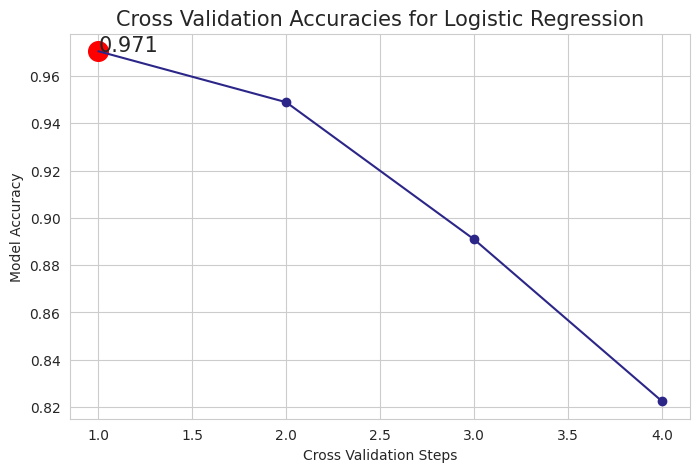

In [ ]:
scatter_plots(lr_grid_result, 'Logistic Regression')

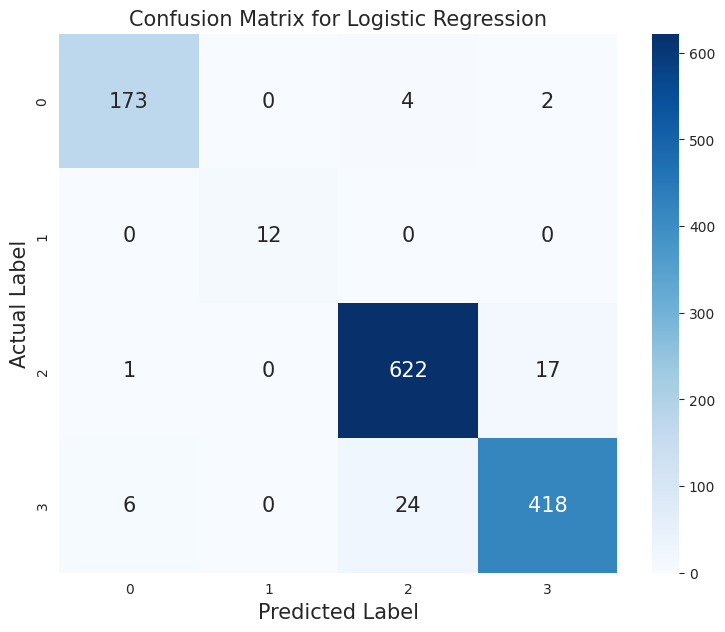

In [ ]:
best_model = lr_grid_result.best_estimator_
cf_plot(best_model, X_test_pca, y_test, 'Logistic Regression')


SVM

In [18]:
svm_model = SVC()
c_ = [0.5,1,2,5,10]
kernel = ['rbf','poly']

search_parameters = dict()
search_parameters['C'] = c_
search_parameters['kernel'] = kernel

svm_grid_result = train_model(svm_model,search_parameters, X_pca, y_train)
svm_grid_result.best_params_

{'C': 5, 'kernel': 'rbf'}

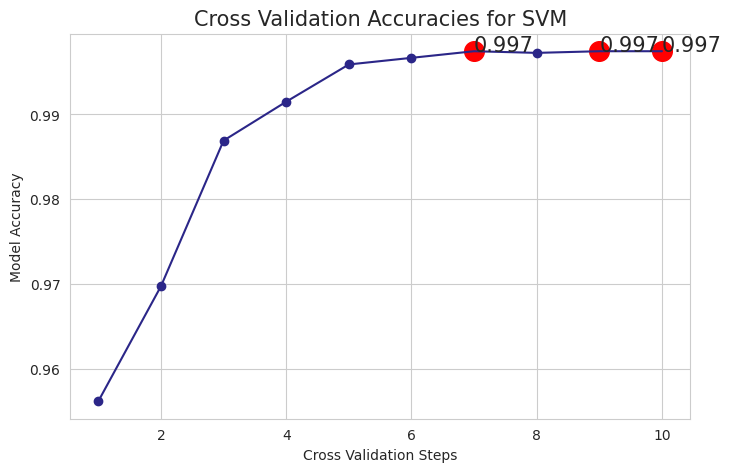

In [19]:
scatter_plots(svm_grid_result,'SVM')

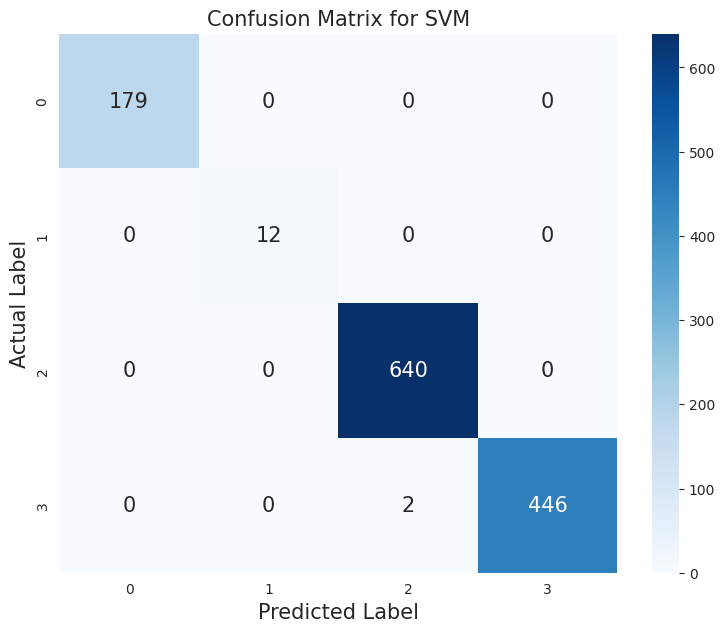

In [21]:
best_model = svm_grid_result.best_estimator_
cf_plot(best_model, X_test_pca, y_test, 'SVM')